In [56]:
print('-'*20)
print('Importing python modules')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
import datetime
import csv
%matplotlib inline
from scipy.optimize import minimize
print('')
print('...Python Modules imported...')

#========== model parameters ==========

A = float(177);       # Catchment area [k^2]
A1 = float(0.134)       # [0-1]
A2 = float(0.433)       # [0-1]
A3 = 1- A1 - A2       # [0-1]
C1 = float(7)         # [mm]
C2 = float(70)       # [mm]
C3 = float(150)       # [mm]  
BFI = float(0.35)      # Base flow index [0-1]
Kbase = float(0.95)   # Baseflow recession constant [0-1]
Ksurf = float(0.35)    # Surface flow recession constant [0-1]

# Setting initial storage capacities
S1_0 = float(0)        # Initial storage capacity storage 1 [mm]
S2_0 = float(0)      # Initial storage capacity storage 2 [mm]
S3_0 = float(0)     # Initial storage capacity storage 3 [mm]
BS_0 = float(0)     # Initial storage capacity baseflow store [mm]
SS_0 = float(0)     # Initial storage capacity surface flow store [mm]

# Parameters needed to be calibrate
parameters = [A1,A2,A3,C1,
             C2,C3,BFI,Kbase,Ksurf,
             S1_0,S2_0,S3_0,BS_0,SS_0]

# establishing variables
Date_in = []
Day_in = []
P_in = []
E_in = []
observed_temp = [] #in order to change unit
predcted = []
#date = []
observed = []
result = []

# reading data
infile_name = 'averaged silo data for task 5.csv'
infile_name2 = 'Gauge row data 99-00.csv'

with open(infile_name) as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    next(csvReader)         # skips the 1st row (header information)
    next(csvReader)         # skips the 2nd row (header information)
    for row in csvReader:
        Day_in.append(row[1])
        Date_in.append(row[0])
        P_in.append(row[10])
        E_in.append(row[11])        
del row

#read observed data
with open(infile_name2) as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    next(csvReader)
    next(csvReader)
    next(csvReader)
    next(csvReader) #skip headers
    for row in csvReader:
        observed.append(row[7]) #==========mean value==========!!!
del row

observed =[float(x) for x in observed]

#Converting dates from string to datetime for plotting
dims = np.shape(Date_in)
Date = []
for i in range(0,dims[0]):
    temp_str = Date_in[i]
    if "-" in temp_str:
        temp_PD = datetime.datetime.strptime(temp_str, '%d-%m-%Y')
    else:
        temp_PD = datetime.datetime.strptime(temp_str, '%d/%m/%y %H:%S')
    Date.append(temp_PD)
del temp_str
del temp_PD    
del i
del dims

# Converting missing data to zero values 
Day = np.array(Day_in)
Day[Day==''] = 0
Day=[float(x) for x in Day]

P = np.array(P_in)
P[P==''] = 0               
P=[float(x) for x in P]

E = np.array(E_in)
E[E==''] = 0               
E=[float(x) for x in E]

del Date_in, Day_in, P_in, E_in
print(' ')
print('...input data loaded...')

def AWBM (parameters):
    dims = np.shape(Date)
    dS = []
    S1 = []; S2 = []; S3 = []
    S1_Excess =[]; S2_Excess =[]; S3_Excess =[]
    Total_Excess = []
    BaseFlowRecharge = []
    SurfaceFlowRecharge = []
    BS = []
    SS = []
    Qbase = []
    Qsurf = []
    Qtotal = []
    Q = []
    dS  = P[0]-E[0] # change in storage

    S1_temp = max(parameters[9]+dS,0)
    S1_Excess = max(S1_temp-parameters[3],0)
    S1.append(min(S1_temp,parameters[3]))

    S2_temp = max(parameters[10]+dS,0)
    S2_Excess = max(S2_temp-parameters[4],0)
    S2.append(min(S2_temp,parameters[4]))

    S3_temp = max(parameters[11]+dS,0)
    S3_Excess = max(S3_temp-parameters[5],0)
    S3.append(min(S3_temp,parameters[5]))

    Total_Excess.append((S1_Excess*parameters[0])+(S2_Excess*parameters[1])+(S3_Excess*parameters[2]))

    BaseFlowRecharge = Total_Excess[0] * parameters[6]
    SurfaceFlowRecharge = Total_Excess[0] * (1-parameters[6])

    #BS_temp = (BaseFlowRecharge/2)+BS_0
    BS_temp = BaseFlowRecharge + parameters[12]
    Qbase.append((1-parameters[7])*BS_temp)
    BS.append(max((parameters[12] + BaseFlowRecharge - Qbase[0]),0))

    #SS_temp = (SurfaceFlowRecharge/2)+SS_0
    SS_temp = SurfaceFlowRecharge + parameters[13]
    Qsurf.append((1-parameters[8])*SS_temp)
    SS.append(max((parameters[13] + SurfaceFlowRecharge - Qsurf[0]),0))

    Qtotal.append(Qbase[0] + Qsurf[0])
    Q.append(((Qtotal[0]/1000)*(A*1000*1000))/24/60/60)

    for i in range(1,dims[0]):
        dS = P[i]-E[i] 

        S1_temp = max(S1[i-1]+dS,0)
        S1_Excess = max(S1_temp-parameters[3],0)
        S1.append(min(S1_temp,parameters[3]))

        S2_temp = max(S2[i-1]+dS,0)
        S2_Excess = max(S2_temp-parameters[4],0)
        S2.append(min(S2_temp,parameters[4]))

        S3_temp = max(S3[i-1]+dS,0)
        S3_Excess = max(S3_temp-parameters[5],0)
        S3.append(min(S3_temp,parameters[5]))

        Total_Excess.append((S1_Excess*parameters[0])+(S2_Excess*parameters[1])+(S3_Excess*parameters[2]))

        BaseFlowRecharge = Total_Excess[i] * parameters[6]
        SurfaceFlowRecharge = Total_Excess[i] * (1-parameters[6])

    #   BS_temp = (BaseFlowRecharge/2)+BS[i-1] 
        BS_temp = BaseFlowRecharge + BS[i-1]
        Qbase.append((1-parameters[7])*BS_temp)
        BS.append(max((BS[i-1] + BaseFlowRecharge - Qbase[i]),0))

    #   SS_temp = (SurfaceFlowRecharge/2)+SS[i-1]
        SS_temp = SurfaceFlowRecharge + SS[i-1]
        Qsurf.append((1-parameters[8])*SS_temp)
        SS.append(max((SS[i-1] + SurfaceFlowRecharge - Qsurf[i]),0))

        Qtotal.append(Qbase[i] + Qsurf[i])
        Q.append(((Qtotal[i]/1000)*(A*1000*1000))/24/60/60)
    del dims
    
    # Q = AWBM_List[13]
    AWBM_List = [S1,S2,S3,S1_Excess,S2_Excess,
                        S3_Excess,Total_Excess,BaseFlowRecharge,
                        BS,SS,Qbase,Qsurf,Qtotal,Q]

    predcted = AWBM_List[13]
    predcted = [float(x) for x in predcted]
    dims = np.shape(Date)
    #====================================#
    #======NSE and R^2 to calibrate======#
    #====================================#

    #set parameters
    pmean = (sum(predcted[0:]))/len(predcted)
    omean = (sum(observed[0:]))/len(observed)

    #initialising variables for calculate

    o_minus_omean = []
    p_minus_pmean = []
    o_minus_omean_and_p = [] #o-omean*p-pmean
    o_minus_omean_square = []
    p_minus_pmean_square = []
    o_minus_p = []
    o_minus_p_square = []
    sum_o_minus_omean = float(0)  #sum all value up later
    sum_p_minus_pmean = float(0)
    sum_o_minus_omean_and_p = float(0)
    sum_o_minus_omean_square = float(0)
    sum_p_minus_pmean_square = float(0)
    sum_o_minus_p = float(0)
    sum_o_minus_p_square = float(0)
    sum_d = float(0)
    R_square = float(0)
    NSE = float(0)
    critical = float(0)

    #===================for cycle to get every value=======================
    for i in range(0,dims[0]):
      #0-0mean 
        o_minus_omean_temp = observed[i]-omean
        o_minus_omean.append(o_minus_omean_temp)

      #p-pmean
        p_minus_pmean_temp = predcted[i]-pmean
        p_minus_pmean.append(p_minus_pmean_temp)

      #(o-omean)*(p-pmean)
        o_minus_omean_and_p.append((observed[i]-omean)*(predcted[i]-pmean))

      #(o-omean)2
        o_minus_omean_square.append((observed[i]-omean)**2)
      #(p-pmean)2
        p_minus_pmean_square.append((predcted[i]-pmean)**2)
      #o-p & (o-p)2
        o_minus_p.append(observed[i]-predcted[i])
        o_minus_p_square.append((observed[i]-predcted[i])**2)

      #sum
        sum_o_minus_omean+= observed[i]-omean
        sum_p_minus_pmean+= predcted[i]-pmean
        sum_o_minus_omean_and_p+= (observed[i]-omean)*(predcted[i]-pmean)
        sum_o_minus_omean_square+= (observed[i]-omean)**2
        sum_p_minus_pmean_square+= (predcted[i]-pmean)*(predcted[i]-pmean)
        sum_o_minus_p+= observed[i]-predcted[i]
        sum_o_minus_p_square+= ((observed[i]-predcted[i])**2)
        sum_d +=(abs(predcted[i]-omean)+abs(o_minus_omean[i]))**2
        
    #====testing=========
    #R^2&NSE&d
    R_square = (sum_o_minus_omean_and_p/(np.sqrt(sum_o_minus_omean_square)*np.sqrt(sum_p_minus_pmean_square)))**2
    NSE = 1-(sum_o_minus_p_square/sum_o_minus_omean_square)
    d = 1-((sum_o_minus_p_square)/(sum_d))
    critical = 2 - (R_square + NSE)
    
    return critical

AWBM(parameters)

#set boundary
#A1-3 [0-1] C1[0-50] C2[0-200] C3[0-500]
b1 = [0.0,1.0]
b2 = [0.0,50.0]
b3 = [0.0,200.0]
b4 = [0.0,500.0]
b5 = [0.0,999999.0]
#boundary for all parameters
bnbs = [b1,b1,b1,b2,b3,b4,b1,b1,b1,b5,b5,b5,b5,b5]

res = minimize(AWBM,parameters,
              method = 'SLSQP',
              bounds = bnbs)
print(res)

Calibrated_P = res.x


--------------------
Importing python modules

...Python Modules imported...
 
...input data loaded...
     fun: 0.25876096269267146
     jac: array([ 1.58986449e-03, -6.48468733e-04,  0.00000000e+00,  3.14784050e-03,
       -8.43405724e-06,  0.00000000e+00,  2.11438537e-03, -4.24504280e-03,
        1.07020140e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.28916717e-04,  4.84240055e-03])
 message: 'Optimization terminated successfully.'
    nfev: 1443
     nit: 88
    njev: 88
  status: 0
 success: True
       x: array([1.18545290e-01, 7.12914941e-01, 4.33000000e-01, 2.78993889e+01,
       1.02816786e+02, 1.50000000e+02, 5.96990068e-01, 9.65605506e-01,
       1.30170798e-01, 2.09292492e-03, 0.00000000e+00, 0.00000000e+00,
       2.95524822e+00, 1.43261721e-18])



...plotting data...


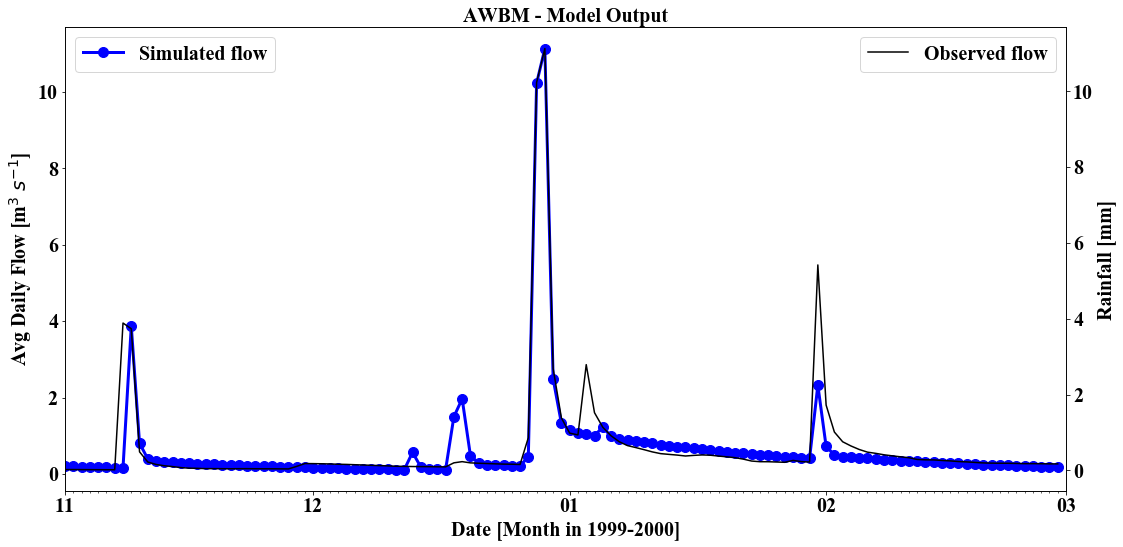

In [57]:
def AWBM (x):
    dims = np.shape(Date)
    dS = []
    S1 = []; S2 = []; S3 = []
    S1_Excess =[]; S2_Excess =[]; S3_Excess =[]
    Total_Excess = []
    BaseFlowRecharge = []
    SurfaceFlowRecharge = []
    BS = []
    SS = []
    Qbase = []
    Qsurf = []
    Qtotal = []
    Q = []
    dS  = P[0]-E[0] # change in storage

    S1_temp = max(x[9]+dS,0)
    S1_Excess = max(S1_temp-x[3],0)
    S1.append(min(S1_temp,x[3]))

    S2_temp = max(x[10]+dS,0)
    S2_Excess = max(S2_temp-x[4],0)
    S2.append(min(S2_temp,x[4]))

    S3_temp = max(x[11]+dS,0)
    S3_Excess = max(S3_temp-x[5],0)
    S3.append(min(S3_temp,x[5]))

    Total_Excess.append((S1_Excess*x[0])+(S2_Excess*x[1])+(S3_Excess*x[2]))

    BaseFlowRecharge = Total_Excess[0] * x[6]
    SurfaceFlowRecharge = Total_Excess[0] * (1-x[6])

    #BS_temp = (BaseFlowRecharge/2)+BS_0
    BS_temp = BaseFlowRecharge + x[12]
    Qbase.append((1-x[7])*BS_temp)
    BS.append(max((x[12] + BaseFlowRecharge - Qbase[0]),0))

    #SS_temp = (SurfaceFlowRecharge/2)+SS_0
    SS_temp = SurfaceFlowRecharge + x[13]
    Qsurf.append((1-x[8])*SS_temp)
    SS.append(max((x[13] + SurfaceFlowRecharge - Qsurf[0]),0))

    Qtotal.append(Qbase[0] + Qsurf[0])
    Q.append(((Qtotal[0]/1000)*(A*1000*1000))/24/60/60)

    for i in range(1,dims[0]):
        dS = P[i]-E[i] 

        S1_temp = max(S1[i-1]+dS,0)
        S1_Excess = max(S1_temp-x[3],0)
        S1.append(min(S1_temp,x[3]))

        S2_temp = max(S2[i-1]+dS,0)
        S2_Excess = max(S2_temp-x[4],0)
        S2.append(min(S2_temp,x[4]))

        S3_temp = max(S3[i-1]+dS,0)
        S3_Excess = max(S3_temp-x[5],0)
        S3.append(min(S3_temp,x[5]))

        Total_Excess.append((S1_Excess*x[0])+(S2_Excess*x[1])+(S3_Excess*x[2]))

        BaseFlowRecharge = Total_Excess[i] * x[6]
        SurfaceFlowRecharge = Total_Excess[i] * (1-x[6])

    #   BS_temp = (BaseFlowRecharge/2)+BS[i-1] 
        BS_temp = BaseFlowRecharge + BS[i-1]
        Qbase.append((1-x[7])*BS_temp)
        BS.append(max((BS[i-1] + BaseFlowRecharge - Qbase[i]),0))

    #   SS_temp = (SurfaceFlowRecharge/2)+SS[i-1]
        SS_temp = SurfaceFlowRecharge + SS[i-1]
        Qsurf.append((1-x[8])*SS_temp)
        SS.append(max((SS[i-1] + SurfaceFlowRecharge - Qsurf[i]),0))

        Qtotal.append(Qbase[i] + Qsurf[i])
        Q.append(((Qtotal[i]/1000)*(A*1000*1000))/24/60/60)
    del dims
    
    # Q = AWBM_List[13]
    AWBM_List = [S1,S2,S3,S1_Excess,S2_Excess,
                        S3_Excess,Total_Excess,BaseFlowRecharge,
                        BS,SS,Qbase,Qsurf,Qtotal,Q]

    predcted = AWBM_List[13]
    predcted = [float(x) for x in predcted]
    return predcted

Q = AWBM(Calibrated_P)

#==========plottttt==========
print('')
print('...plotting data...')
# ========== Setting plot formatting (global settings)==========
mS = 10 # set marker size
lW = 3 # set linewidth
fS = 20 # set font size
plt.rcParams['font.family'] = 'Times New Roman' # Globally sets the font type
plt.rc('font',size=fS)
plt.rc('axes',titlesize=fS)
plt.rc('axes',labelsize=fS)
plt.rc('xtick',labelsize=fS)
plt.rc('ytick',labelsize=fS)
plt.rc('legend',fontsize=fS)
plt.rc('figure',titlesize=fS)

months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%m')
days = mdates.DayLocator()

stDate = datetime.datetime.strptime('1999-11-1', '%Y-%m-%d')
enDate = datetime.datetime.strptime('2000-3-1', '%Y-%m-%d')

# ===== Single plot example =====
fig, ax1 = plt.subplots() #Establishes figure handle
ax2 = ax1.twinx()


tle = 'AWBM - Model Output'

ax1.plot(Date,Q, '-o', c='b',label='Simulated flow',
         markersize=mS,linewidth=lW)
ax2.plot(Date,observed,color='k',label='Observed flow')
ax1.set_xlim(stDate, enDate)
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt)
ax1.xaxis.set_minor_locator(days)

ax1.set_xlabel('Date [Month in 1999-2000]')
ax1.set_ylabel('Avg Daily Flow [m$^3$ $s^{-1}$]')
ax2.set_ylabel('Rainfall [mm]')
ax1.set_title(tle)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#set size
fig.set_figheight(8)
fig.set_figwidth(16)

fig.tight_layout() 

